### Las frecuencias de los tonos son: 19.51, 19.42 y 16.7 MHz. El noise_level está a 0.8

## Config

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget

In [32]:
# import seaborn as sns
# sns.set(style="whitegrid")

#%pylab inline
#plt.rcParams['figure.figsize'] = (10, 6)
##Esto es para renderizar texto con LaTex
#plt.rc('text', usetex = True)
plt.rc('text', usetex = True)
SMALL_SIZE = 25
MEDIUM_SIZE = 32
BIGGER_SIZE = 37

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font',**{'family':'serif','serif':['Times']})
plt.rcParams['figure.figsize'] = (7, 5)

In [33]:
def twos_complement(hexstr,bits):    
    value = int(hexstr,16)    
    if value & (1 << (bits-1)):
        value -= 1 << bits
    return value

In [34]:
def get_data(rawArray, nBits, length=None):
    if length is None:
        length = len(rawArray)
    realPt = np.zeros(length)
    imPt = np.zeros(length)
    t_us = np.zeros(length)
    for i in range(length):
        t_us[i] = rawArray.iloc[i,0]
        strRe = rawArray.iloc[i,2].split('h')[1]
        realPt[i] = twos_complement(strRe,nBits)
        strIm = rawArray.iloc[i,3].split('h')[1]
        imPt[i] = twos_complement(strIm,nBits)
    return [t_us, realPt, imPt]

In [35]:
def fft(data, fs):
    vec = data[1] + 1j*data[2]
    fft = np.fft.fftshift(np.fft.fft(vec))
    freq = np.linspace(-fs/2, fs/2, len(fft))
    return [freq, fft]


## Input Data

In [36]:
dataIn = pd.read_table('tresTonosConMuchoRuidoNuevasFreqs/dataIn.lst', sep=' ', skipinitialspace=True, skiprows=3, keep_default_na = False, header=None)

In [37]:
def get_data_real(rawArray, nBits, length=None):
    if length is None:
        length = len(rawArray)
    realPt = np.zeros(length)
    t_us = np.zeros(length)
    for i in range(length):
        t_us[i] = rawArray.iloc[i,0]
        strRe = rawArray.iloc[i,2].split('h')[1]
        realPt[i] = twos_complement(strRe,nBits)
    return [t_us, realPt]

In [38]:
dataInData = get_data_real(dataIn, 16,6000)

Text(0.5, 0, 'Time [us]')

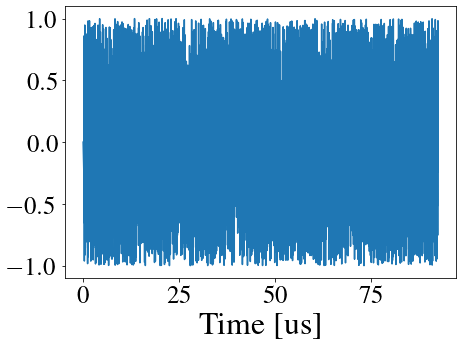

In [39]:
plt.figure()
plt.plot(dataInData[0]*1e-6, dataInData[1]/max(dataInData[1]))
plt.xlabel('Time [us]')
#plt.xlim([30,31])
#plt.tight_layout()
#plt.savefig("tresTonosConRuido/dataIn.png")

In [40]:
np.mean(dataInData[1])

-3.31

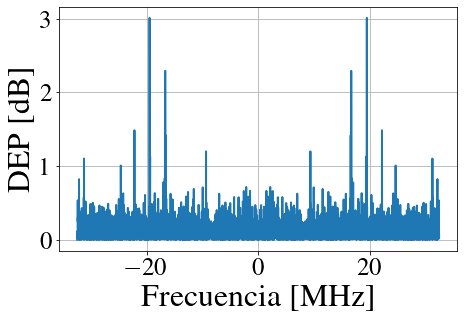

In [41]:
fftData = np.fft.fftshift(np.fft.fft(dataInData[1]))
fs = 65e6
freq = np.linspace(-fs/2, fs/2, len(fftData))
dep =  np.abs(fftData)**2
dep_db = 10*np.log10(1 + dep/max(dep))
plt.figure()
plt.plot(freq*1e-6, dep_db,linewidth=2)
plt.xlabel('Frecuencia [MHz]')
plt.ylabel('DEP [dB]')
plt.grid()
plt.tight_layout()
plt.savefig('tresTonosConMuchoRuidoNuevasFreqs/dataInFreq_db.pdf')


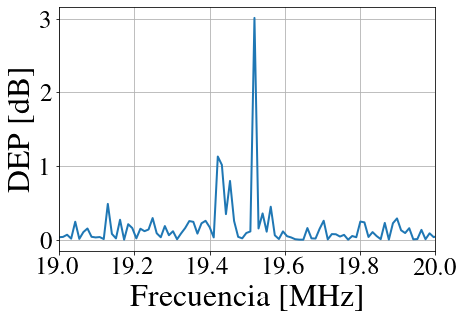

In [55]:
fftData = np.fft.fftshift(np.fft.fft(dataInData[1]))
fs = 65e6
freq = np.linspace(-fs/2, fs/2, len(fftData))
dep =  np.abs(fftData)**2
dep_db = 10*np.log10(1 + dep/max(dep))
plt.figure()
plt.plot(freq*1e-6, dep_db,linewidth=2)
plt.xlabel('Frecuencia [MHz]')
plt.ylabel('DEP [dB]')
plt.xlim([19,20])
plt.grid()
plt.tight_layout()
plt.savefig('tresTonosConMuchoRuidoNuevasFreqs/dataInFreq_db_zoom.pdf')

In [43]:
fs = 65e6
grouping_factor = 500
datita = dataInData[1][0:grouping_factor]
length = len(np.fft.fft(datita))
freq = np.linspace(-fs/2, fs/2, length)
fftSum = np.zeros(length)
for i in range(len(dataInData[1])//grouping_factor):
    fftData = np.fft.fftshift(np.fft.fft(dataInData[1][i*grouping_factor:(i+1)*grouping_factor]))
    fftSum += np.abs(fftData)**2

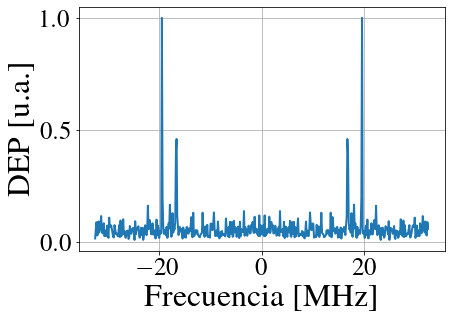

In [44]:
dep =  np.abs(fftSum)**2
dep_db = 10*np.log10(dep/max(dep))
plt.figure()
plt.plot(freq*1e-6, dep/max(dep),linewidth=2)
plt.xlabel('Frecuencia [MHz]')
plt.ylabel('DEP [u.a.]')
#plt.ylim([-10,0])
plt.grid()
plt.tight_layout()
plt.savefig('tresTonosConMuchoRuidoNuevasFreqs/dataInFreq_db_sum.pdf')

## Band Filter

In [45]:
bandFilter = pd.read_table('tresTonosConMuchoRuidoNuevasFreqs/bandFilter.lst', sep=' ', skipinitialspace=True, skiprows=2, keep_default_na = False, header=None)

In [46]:
bandFilterData = get_data(bandFilter, 16)

Text(0.5, 0, 'Time [us]')

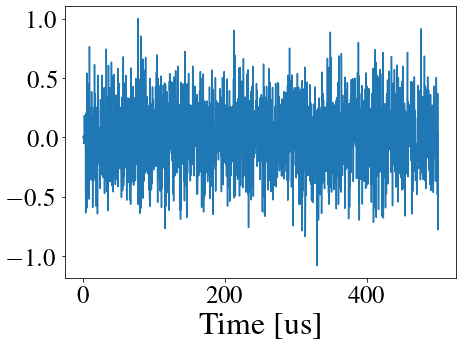

In [47]:
plt.figure()
plt.plot(bandFilterData[0]*1e-6, bandFilterData[1]/max(bandFilterData[1]))
plt.xlabel('Time [us]')
#plt.xlim([30,3.31])

In [48]:
fs = 8.125e6
freq, fftData = fft(bandFilterData, fs)

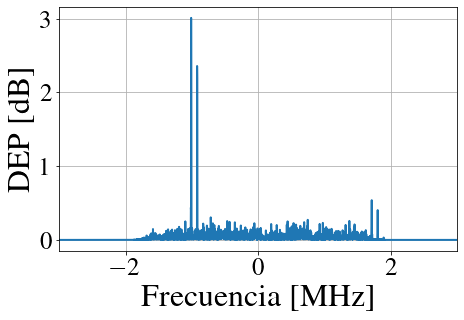

In [49]:
dep = np.abs(fftData)**2
dep_db = 10*np.log10(1 + dep/max(dep))
plt.figure()
plt.plot(freq*1e-6, dep_db,linewidth=2)
plt.xlabel('Frecuencia [MHz]')
plt.ylabel('DEP [dB]')
plt.grid()
plt.xlim([-3,3])
plt.tight_layout()
plt.savefig('tresTonosConMuchoRuidoNuevasFreqs/bandFilterFreq.pdf')

## Channel Filter

In [50]:
channelFilter = pd.read_table('tresTonosConMuchoRuidoNuevasFreqs/channelFilter.lst', sep=' ', skipinitialspace=True, skiprows=2, keep_default_na = False, header=None)

In [51]:
channelFilterData = get_data(channelFilter, 40)

Text(0.5, 0, 'Time [us]')

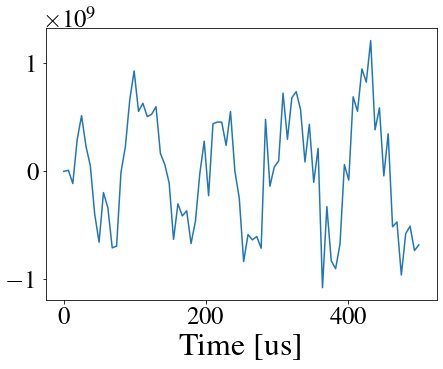

In [52]:
plt.figure()
plt.plot(channelFilterData[0]*1e-6, channelFilterData[1])
plt.xlabel('Time [us]')
#plt.xlim([3e13,3.3e13])

In [53]:
fs = 162.5e3
freq, fftData = fft(channelFilterData, fs)

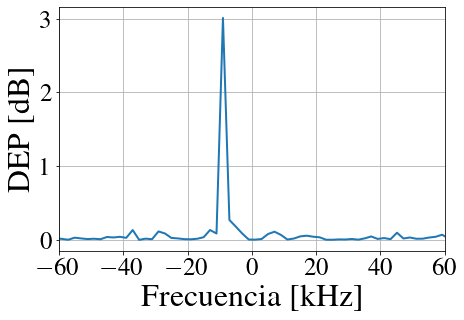

In [54]:
dep = np.abs(fftData)**2
dep_db = 10*np.log10(1 + dep/max(dep))
plt.figure()
plt.plot(freq*1e-3, dep_db, linewidth=2)
plt.xlabel('Frecuencia [kHz]')
plt.ylabel('DEP [dB]')
plt.xlim([-50,50])
plt.xticks(np.arange(-60,61,20))
plt.grid()
plt.tight_layout()
plt.savefig('tresTonosConMuchoRuidoNuevasFreqs/channelFreq.pdf')
plt.show()